# Imports

In [53]:
from importlib import reload
from math import log, exp, sqrt, isnan

import numpy as np
import numbers

from tqdm import tqdm
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import hyperopt
from hyperopt import fmin, hp, tpe, Trials

In [2]:
def parent_folder_to_sys_path():
    import os, sys
    dir2 = os.path.abspath('')
    dir1 = os.path.dirname(dir2)
    if not dir1 in sys.path: sys.path.append(dir1)
        
parent_folder_to_sys_path()

In [3]:
from ml_utils import utils

# Visualization settings

In [4]:
pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (15,5)

# Data Loading

In [5]:
raw_train = pd.read_csv(
    "../input/house-prices-advanced-regression-techniques/train.csv")
raw_test = pd.read_csv(
    "../input/house-prices-advanced-regression-techniques/test.csv")

## Combining train and test datasets into one for further processing

In [6]:
raw_train_copy = raw_train.copy()
raw_train_copy['train'] = True

raw_test_copy = raw_test.copy()
raw_test_copy['train'] = False

combined_data = pd.concat([raw_train_copy, raw_test_copy], axis=0)

# Data Inspection

In [7]:
combined_data['Id'].unique()

array([   1,    2,    3, ..., 2917, 2918, 2919], dtype=int64)

## Checking that all ids in combined dataset are unique

In [8]:
len(combined_data['Id']) == len(combined_data['Id'].unique())

True

## Show how filled are the columns

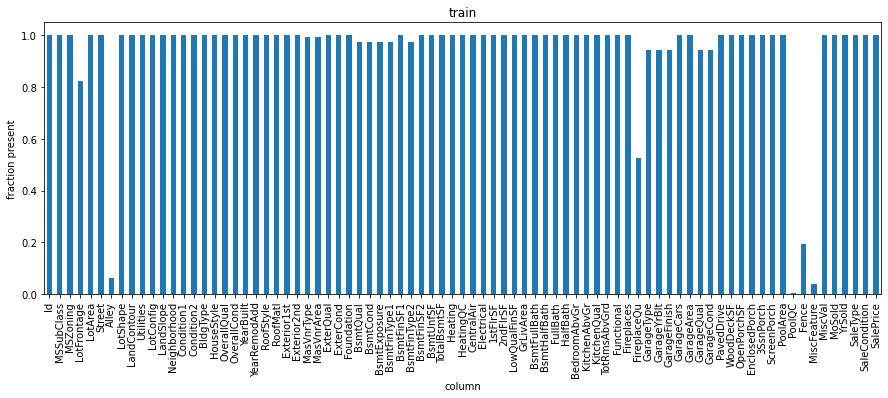

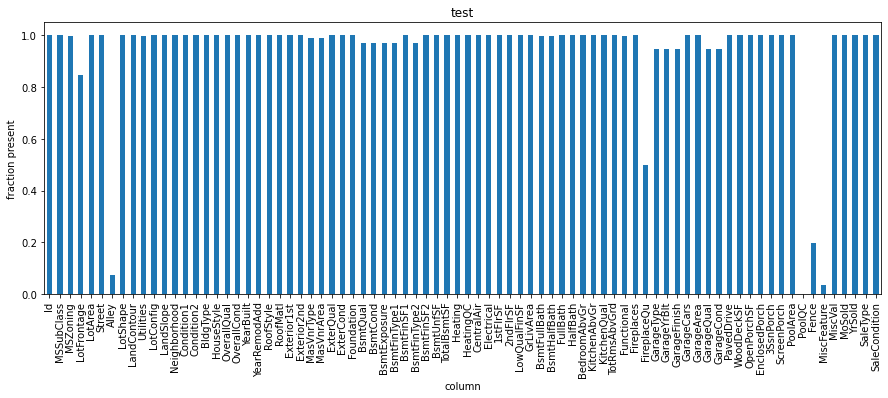

In [9]:
perc_train = utils.get_not_nans_fraction_by_column(raw_train)
perc_train.plot.bar()
plt.title('train')
plt.xlabel('column')
plt.ylabel('fraction present')
plt.show()

perc_test = utils.get_not_nans_fraction_by_column(raw_test)
perc_test.plot.bar()
plt.title('test')
plt.xlabel('column')
plt.ylabel('fraction present')
plt.show()

# Data preparation

In [232]:
combined_data = pd.concat([raw_train_copy, raw_test_copy], axis=0)

## Creating new features

In [233]:
combined_data['has_basement'] = combined_data['BsmtQual'].notna()
combined_data['has_garage'] = combined_data['GarageType'].notna()
combined_data['has_fence'] = combined_data['Fence'].notna()
combined_data['has_fireplace'] = combined_data['FireplaceQu'].notna()

# combined_data['years_since_built'] = combined_data['YearBuilt'] - combined_data['YrSold']
# combined_data['years_since_remodelled'] = combined_data['YearRemodAdd'] - combined_data['YrSold']

In [234]:
combined_data.values[:, -1] = np.repeat(True, len(combined_data))
combined_data.values

array([[1, 60, 'RL', ..., True, False, False],
       [2, 20, 'RL', ..., True, False, True],
       [3, 60, 'RL', ..., True, False, True],
       ...,
       [2917, 20, 'RL', ..., True, False, True],
       [2918, 85, 'RL', ..., False, True, False],
       [2919, 60, 'RL', ..., True, False, True]], dtype=object)

## Numerical and categorical split

In [235]:
numerical, categorical = utils.num_cat_split(combined_data.drop(columns='train'))

Numerical dtypes are ['int64', 'float64', 'bool']
Numerical columns are ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'has_basement', 'has_fence', 'has_fireplace', 'has_garage']


Categorical dtypes are ['object']
Categorical columns are ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 

## Unify all rarely used categories into one

In [236]:
for column in categorical.columns:
    for value in categorical[column].dropna().unique():
        if categorical[column].value_counts()[value] < 15:
            categorical[column] = categorical[column].replace(value, 'Rare_value')

## One-hot encoding all categorical data

In [237]:
categorical_with_dummies = pd.get_dummies(categorical)

## Merging all data and splitting it into train, validation and test sets

In [238]:
combined_data = pd.concat([
    categorical_with_dummies, numerical, combined_data[['train']]], axis=1)

In [239]:
full_train = combined_data[combined_data['train'] == True].drop(columns=['Id', 'train'])
target = full_train['SalePrice']
full_train = full_train.drop(columns='SalePrice')

test = combined_data[combined_data['train'] == False].drop(columns=['Id', 'train', 'SalePrice'])

x_train, x_val, y_train, y_val = [df.reset_index(drop=True) for df in \
    train_test_split(full_train, target, test_size=0.20, random_state=100)] #remove reset index

## Some other preprocessing operations, that didn't lead to improvement in score and were refused:

- Impute nans with mean, median or most frequent value
- Remove 60, 120, 180 most usless features, according to XGBoost feature rating
- For all features create an indicator that shows if that feature is missing
- Creating features years_since_remodelled and years_since_built
- Turning some categorical features representing quantity or quality into numeric

# Model selection using hyperopt

In [17]:
NONOPTIMIZED_XGB_SETTINGS = dict(
    booster='gbtree',
    importance_type='gain',
    n_estimators=2400,
    n_jobs=4)

## Initializing trials object and dataframe with statistics

In [18]:
trials = Trials()
hyperopt_stats = pd.DataFrame()

## Defining search space and objective function

In [20]:
space = {
     'objective': hp.choice('objective', ['reg:squarederror',
                                          'reg:pseudohubererror']),
     'learning_rate': hp.loguniform('learning_rate', log(0.005), log(0.1)),
     'max_depth': hp.choice('max_depth', [3, 4, 5, 6, 7, 8]),
     'min_child_weight': hp.uniform('min_child_weight', 0.8, 4),
     'subsample': hp.uniform('subsample', 0.01, 1),
     'colsample_bytree': hp.uniform('colsample_bytree', 0.01, 1),
     'colsample_bynode': hp.uniform('colsample_bynode', 0.01, 1),
     'min_split_loss': hp.uniform('min_split_loss', 0, 0.15),
}


def objective(args):
    xgb =XGBRegressor(
        **NONOPTIMIZED_XGB_SETTINGS,
        **args,
    )

    res = cross_validate(xgb, x_train.values, y_train.values,
                         n_jobs=-1, cv=4, scoring='neg_mean_squared_log_error',
                         return_train_score=True)
    means = {key: np.sqrt(-value).mean() for key, value in res.items() if key in ['train_score', 'test_score']}
    
    row = {**args, **means}#, 'independent_test_score': independent_test_score}
    global hyperopt_stats
    hyperopt_stats = hyperopt_stats.append(row, ignore_index = True)
    return np.sqrt(means['test_score'])

## Launching hyperopt (takes several hours)

In [21]:
# minimize the objective over the space

best = fmin(objective, space, trials = trials, algo=tpe.suggest, max_evals=700)
best_params = hyperopt.space_eval(space, best)

100%|███████████████████████████████████████████| 700/700 [2:39:35<00:00, 13.68s/trial, best loss: 0.12376406282365292]


In [42]:
# correcting mistake in objective
hyperopt_stats[['train_score', 'test_score']] = np.sqrt(hyperopt_stats[['train_score', 'test_score']])

In [22]:
best_params

{'colsample_bynode': 0.3062229964392108,
 'colsample_bytree': 0.5056031654666078,
 'learning_rate': 0.018004670289342686,
 'max_depth': 4,
 'min_child_weight': 1.2798161104441208,
 'min_split_loss': 0.030476316096001016,
 'objective': 'reg:squarederror',
 'subsample': 0.7595298526466023}

## Shortcut for skipping hyperopt

In [73]:
best_params = {
 'colsample_bynode': 0.3062229964392108,
 'colsample_bytree': 0.5056031654666078,
 'learning_rate': 0.018004670289342686,
 'max_depth': 4,
 'min_child_weight': 1.2798161104441208,
 'min_split_loss': 0.030476316096001016,
 'objective': 'reg:squarederror',
 'subsample': 0.7595298526466023}

## Viewing stats

In [64]:
hyperopt_stats.sort_values(by = 'test_score', ascending=False)

,colsample_bynode,colsample_bytree,learning_rate,max_depth,min_child_weight,min_split_loss,objective,subsample,test_score,train_score,independent_validation_score
341,0.468420,0.164373,0.009698,8.0,2.598504,0.117215,reg:pseudohubererror,0.108347,4.338628,4.338628,NaN
123,0.377152,0.693207,0.006425,5.0,1.548768,0.145594,reg:pseudohubererror,0.210587,4.089923,4.089923,NaN
7,0.969049,0.836622,0.005160,6.0,3.079674,0.005050,reg:pseudohubererror,0.449741,3.553688,3.553688,NaN
45,0.809764,0.215961,0.006350,3.0,1.957910,0.084006,reg:pseudohubererror,0.371275,3.537567,3.537567,NaN
143,0.037351,0.449885,0.005231,6.0,2.173991,0.086125,reg:pseudohubererror,0.510920,3.413490,3.413490,NaN
...,...,...,...,...,...,...,...,...,...,...,...
577,0.270240,0.433038,0.016075,4.0,1.488153,0.016296,reg:squarederror,0.620503,0.123999,0.029971,NaN
611,0.290703,0.602861,0.014387,4.0,1.947630,0.015190,reg:squarederror,0.531883,0.123997,0.032625,NaN
438,0.193815,0.541139,0.011157,4.0,1.248301,0.010488,reg:squarederror,0.616481,0.123893,0.043918,NaN
180,0.213556,0.551510,0.023233,4.0,1.472886,0.136668,reg:squarederror,0.579609,0.123810,0.019571,NaN


## Plotting feature vs loss graphs

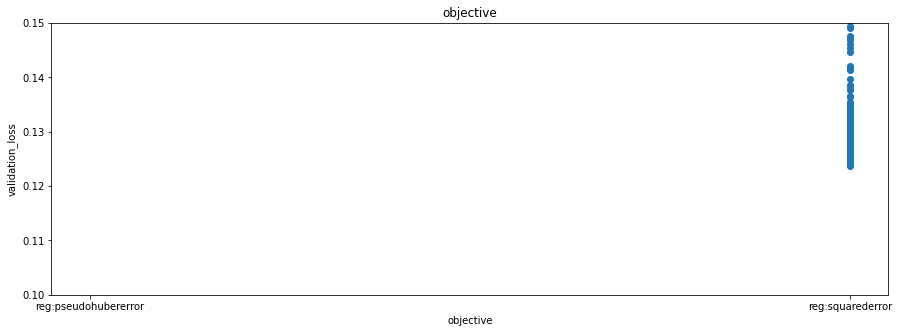

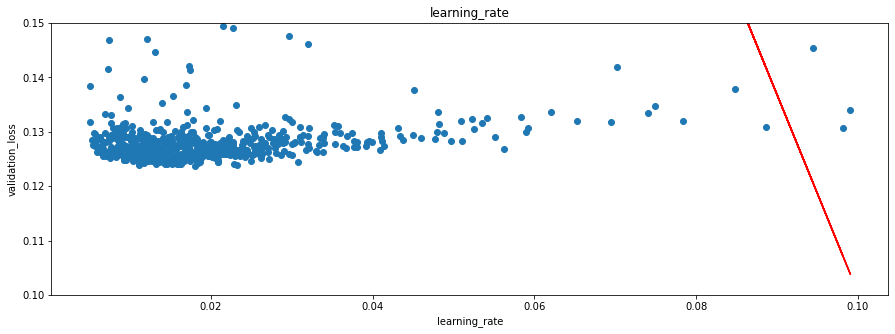

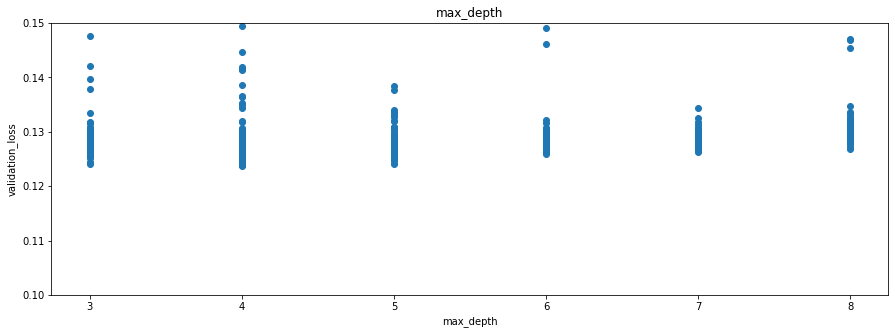

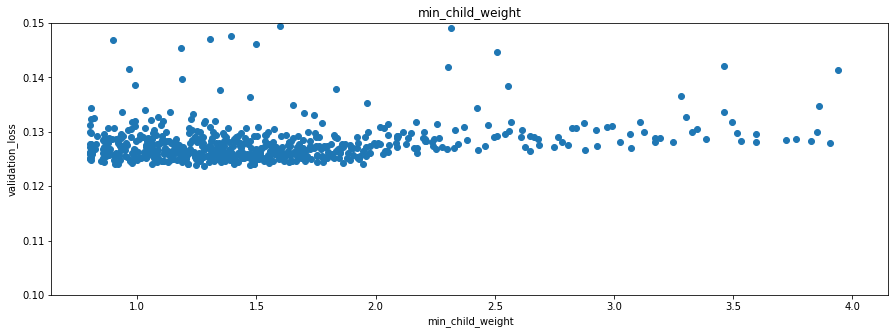

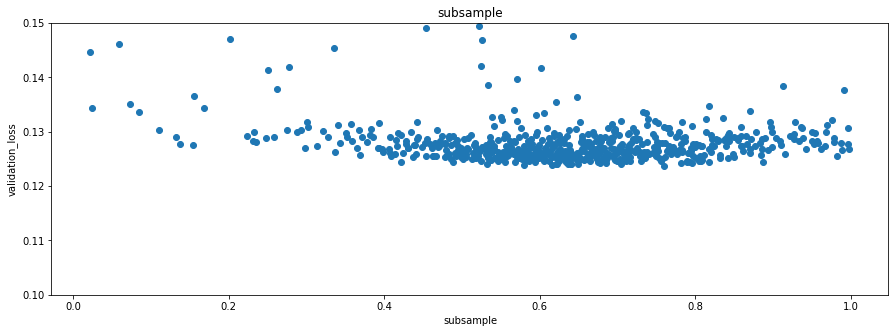

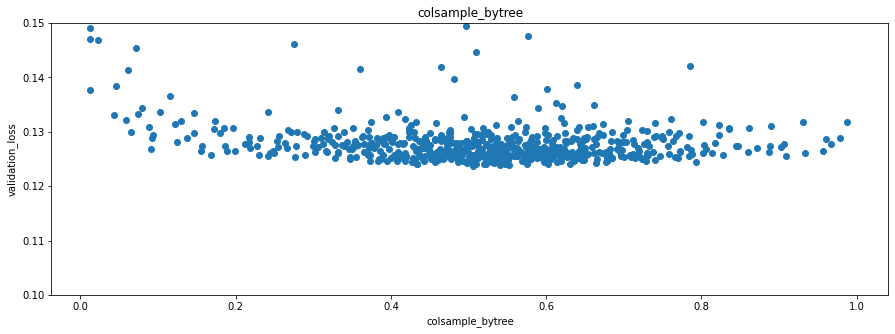

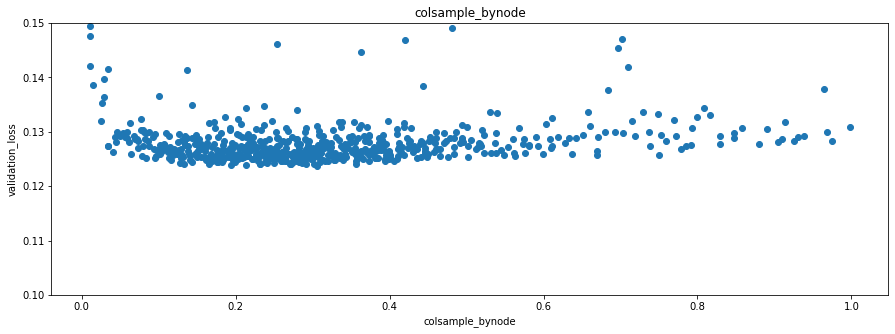

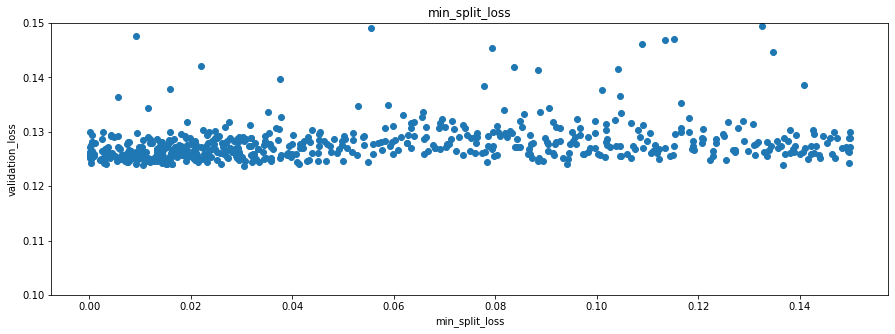

In [45]:
for column in space.keys():
    x = hyperopt_stats[column]
    y = hyperopt_stats['test_score']
    plt.scatter(x, y)
    if hyperopt_stats[column].dtype != 'object':
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x),"r")
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('validation_loss')
    axes = plt.gca()
    axes.set_ylim([0.10, 0.15])
    plt.show()

# Calculating independent validation score

In [228]:
xgb =XGBRegressor(**{
    **NONOPTIMIZED_XGB_SETTINGS,
    **best_params
    }) #25

In [229]:
xgb.fit(x_train, y_train)
prediction = xgb.predict(x_val)
rmse = mean_squared_error(y_val, prediction, squared=False)
rmsle = np.sqrt(mean_squared_log_error(y_val, prediction))
print(f'root mean squared error: {rmse}')
print(f'root mean squared logarithmic error: {rmsle}')

root mean squared error: 23367.509203110327
root mean squared logarithmic error: 0.1209967769430387


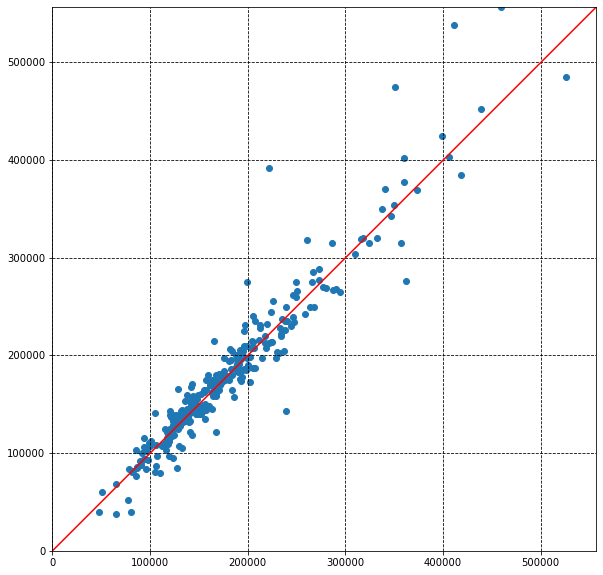

In [230]:
utils.true_vs_prediction_scatter_plot(y_val, prediction)

# Calculating cross validation scores on full data

In [231]:
res = cross_validate(xgb, full_train, target,
                     n_jobs=-1, cv=4, scoring=['neg_mean_squared_error', 'neg_mean_squared_log_error'],
                     return_train_score=True)
print(f'cv scores rmse:\n {np.sort(np.sqrt(-res["test_neg_mean_squared_error"]))}')
print(f'mean:\n {np.sqrt(-res["test_neg_mean_squared_error"].mean())}\n')

print(f'cv scores rmsle:\n {np.sort(np.sqrt(-res["test_neg_mean_squared_log_error"]))}')
print(f'mean:\n {np.sqrt(-res["test_neg_mean_squared_log_error"].mean())}\n')

cv scores rmse:
 [20548.949565   23448.24616065 24245.41825012 30549.07062277]
mean:
 24965.804604865963

cv scores rmsle:
 [0.10041722 0.11257034 0.1171963  0.14279002]
mean:
 0.11924728681363422



# Calculating independent validation score

In [240]:
xgb =XGBRegressor(**{
    **NONOPTIMIZED_XGB_SETTINGS,
    **best_params
    })# 40

In [241]:
xgb.fit(x_train, y_train)
prediction = xgb.predict(x_val)
rmse = mean_squared_error(y_val, prediction, squared=False)
rmsle = np.sqrt(mean_squared_log_error(y_val, prediction))
print(f'root mean squared error: {rmse}')
print(f'root mean squared logarithmic error: {rmsle}')

root mean squared error: 23251.450352104614
root mean squared logarithmic error: 0.12347827471291119


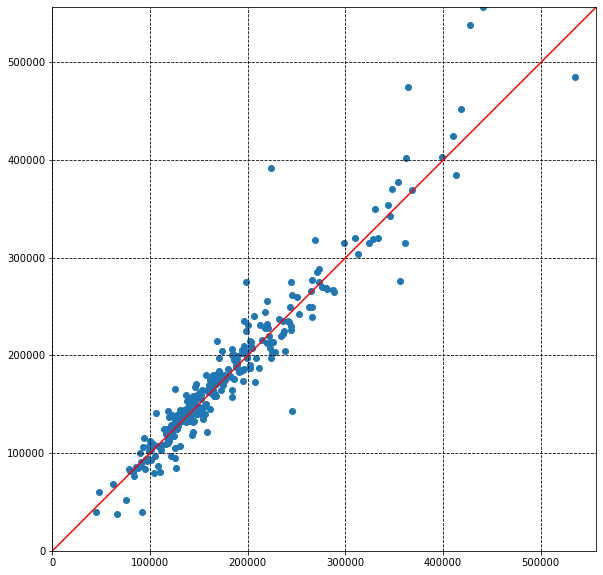

In [242]:
utils.true_vs_prediction_scatter_plot(y_val, prediction)

# Calculating cross validation scores on full data

In [243]:
res = cross_validate(xgb, full_train, target,
                     n_jobs=-1, cv=4, scoring=['neg_mean_squared_error', 'neg_mean_squared_log_error'],
                     return_train_score=True)
print(f'cv scores rmse:\n {np.sort(np.sqrt(-res["test_neg_mean_squared_error"]))}')
print(f'mean:\n {np.sqrt(-res["test_neg_mean_squared_error"].mean())}\n')

print(f'cv scores rmsle:\n {np.sort(np.sqrt(-res["test_neg_mean_squared_log_error"]))}')
print(f'mean:\n {np.sqrt(-res["test_neg_mean_squared_log_error"].mean())}\n')

cv scores rmse:
 [21054.27168313 23477.29740722 25853.96312393 30210.70645382]
mean:
 25375.086420085085

cv scores rmsle:
 [0.10387152 0.11403158 0.12194125 0.14309222]
mean:
 0.12159106377980379



# Calculating independent validation score

In [244]:
xgb =XGBRegressor(**{
    **NONOPTIMIZED_XGB_SETTINGS,
    **best_params
    })# 10

In [245]:
xgb.fit(x_train, y_train)
prediction = xgb.predict(x_val)
rmse = mean_squared_error(y_val, prediction, squared=False)
rmsle = np.sqrt(mean_squared_log_error(y_val, prediction))
print(f'root mean squared error: {rmse}')
print(f'root mean squared logarithmic error: {rmsle}')

root mean squared error: 23251.450352104614
root mean squared logarithmic error: 0.12347827471291119


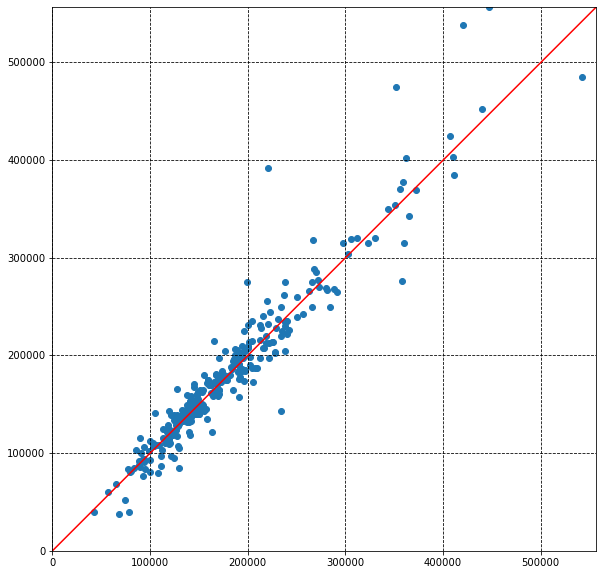

In [207]:
utils.true_vs_prediction_scatter_plot(y_val, prediction)

# Calculating cross validation scores on full data

In [208]:
res = cross_validate(xgb, full_train, target,
                     n_jobs=-1, cv=4, scoring=['neg_mean_squared_error', 'neg_mean_squared_log_error'],
                     return_train_score=True)
print(f'cv scores rmse:\n {np.sort(np.sqrt(-res["test_neg_mean_squared_error"]))}')
print(f'mean:\n {np.sqrt(-res["test_neg_mean_squared_error"].mean())}\n')

print(f'cv scores rmsle:\n {np.sort(np.sqrt(-res["test_neg_mean_squared_log_error"]))}')
print(f'mean:\n {np.sqrt(-res["test_neg_mean_squared_log_error"].mean())}\n')

cv scores rmse:
 [20872.32187023 22485.06475689 26306.73723508 30469.86701065]
mean:
 25306.56622785164

cv scores rmsle:
 [0.10358019 0.10886606 0.12021368 0.14296385]
mean:
 0.11986520356377685



# Submition

In [47]:
xgb =XGBRegressor(
    **NONOPTIMIZED_XGB_SETTINGS,
    **best_params)
xgb.fit(full_train, target) #old
prediction = xgb.predict(test)

In [48]:
prediction

array([126262.65, 161097.89, 185737.17, ..., 167273.4 , 116895.01,
       221053.05], dtype=float32)

In [49]:
submission = pd.DataFrame({
        "Id": raw_test["Id"],
        "SalePrice": prediction
    })
submission.to_csv('submission.csv', index=False)

# Additional exploration

## Comparing cv score during training with independent test score (may take several hours)

In [50]:
if 'independent_validation_score' not in hyperopt_stats.columns:
    hyperopt_stats['independent_validation_score'] = np.nan

In [71]:
for i, row in tqdm(list(hyperopt_stats.iterrows())):
    if isnan(row['independent_validation_score']):
        row_dict = row.to_dict()
        params = {param_name: param for param_name, param in row_dict.items() if param_name in space}
        params['max_depth'] = int(params['max_depth'])
        xgb =XGBRegressor(
        **NONOPTIMIZED_XGB_SETTINGS,
        **params)
        xgb.fit(x_train, y_train)
        prediction = xgb.predict(x_val)
        rmsle = np.sqrt(mean_squared_log_error(y_val, prediction))
        hyperopt_stats.loc[i, 'independent_validation_score'] = rmsle
        

100%|██████████████████████████████████████████████████████████████████████████████| 700/700 [1:04:55<00:00,  5.57s/it]


In [69]:
hyperopt_stats['independent_validation_score'].notna().sum()

3

train_score_cv                  0.021975
test_score_cv                   0.123764
independent_validation_score    0.122273
Name: 0, dtype: float64

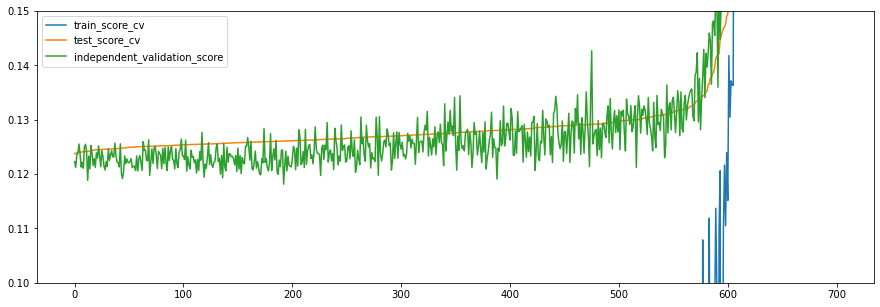

In [72]:
ranked_stats = hyperopt_stats.sort_values(by= 'test_score').reset_index(drop = True)
scores = ranked_stats[['train_score', 'test_score', 'independent_validation_score']]
scores = scores.rename(columns={'train_score': 'train_score_cv', 'test_score': 'test_score_cv'})
scores.plot()
axes = plt.gca()
axes.set_ylim([0.10, 0.15])
# plt.axhline(y=26350, color='r', linestyle='-')
scores.iloc[0]



## Viewing how increase in tree count impacts train and test scores

In [ ]:
train_metrics = []
val_metrics = []

for n_est in range(100, 2500, 100):
    settings = {**NONOPTIMIZED_XGB_SETTINGS, **best_params}
    settings['n_estimators'] = n_est
    xgb =XGBRegressor(
            **settings
    )
    xgb.fit(x_train, y_train)
    prediction_val = xgb.predict(x_val)
    prediction_train = xgb.predict(x_train)
    val_metrics.append(mean_squared_error(y_val, prediction_val, squared=False))
    train_metrics.append(mean_squared_error(y_train, prediction_train, squared=False))
    

In [ ]:
plt.plot(range(100, 2500, 100), train_metrics, label = 'train')
plt.plot(range(100, 2500, 100), val_metrics, label = 'validation')
plt.legend()
plt.xlabel('n_estimators')

## Feature importances

In [ ]:
importances = pd.Series(dict(zip(x_train.columns, xgb.feature_importances_)))
importances = importances.sort_values(ascending = False)
importances[:20].plot.bar()